# Проект "Реклама Procrastinate Pro+"

Задачей проекта является исследование расходов на рекламу приложения Procrastinate Pro+, терпящего последние несколько месяцев убытки, и выяснение причин происходящего.

В распоряжении имеются данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
- лог сервера с данными об их посещениях,
- выгрузка их покупок за этот период,
- рекламные расходы.

Необходимо выяснить:
- откуда приходят пользователи и какими устройствами они пользуются,
- сколько стоит привлечение пользователей из различных рекламных каналов;
- сколько денег приносит каждый клиент,
- когда расходы на привлечение клиента окупаются,
- какие факторы мешают привлечению клиентов.

### 1. Загрузка данных 

Загрузите данные о визитах, заказах и рекламных расходах из CSV-файлов в переменные.

**Пути к файлам**

- визиты: `/datasets/visits_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/visits_info_short.csv);
- заказы: `/datasets/orders_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/orders_info_short.csv);
- расходы: `/datasets/costs_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/costs_info_short.csv).

Изучите данные и выполните предобработку. Есть ли в данных пропуски и дубликаты? Убедитесь, что типы данных во всех колонках соответствуют сохранённым в них значениям. Обратите внимание на столбцы с датой и временем.

#### 1.1 Загрузка библиотек

In [58]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import plotly.express as px

#Для корректного отображения графиков plotly установлю библиотеки для перевода графиков в формат картинки
!pip install -U kaleido==0.2.1
import kaleido
import plotly.io as pio
pio.renderers.default = 'png'

     |████████████████████████████████| 79.9 MB 15.0 MB/s eta 0:00:01


#### Загрузка датасетов

In [7]:
#для работы онлайн и локально
try:
    visits, orders, costs = (
    pd.read_csv('/datasets/visits_info_short.csv'),  # визиты
    pd.read_csv('/datasets/orders_info_short.csv'),  # заказы
    pd.read_csv('/datasets/costs_info_short.csv'),  # расходы     
)
except:
    visits, orders, costs = (
    pd.read_csv('C:/Users/Ростислав/Desktop/JN/Проекты/Мастерская/kiva.csv'),  # визиты
    pd.read_csv('C:/Users/Ростислав/Desktop/JN/Проекты/Мастерская/kiva.csv'),  # заказы
    pd.read_csv('C:/Users/Ростислав/Desktop/JN/Проекты/Мастерская/kiva.csv'),  # расходы     
)
display(visits)
display(orders)
costs

User Id         Region   Device         Channel  \
0       981449118918  United States   iPhone         organic   
1       278965908054  United States   iPhone         organic   
2       590706206550  United States      Mac         organic   
3       326433527971  United States  Android          TipTop   
4       349773784594  United States      Mac         organic   
...              ...            ...      ...             ...   
309896  329994900775             UK       PC         LeapBob   
309897  334903592310         France       PC  lambdaMediaAds   
309898  540102010126        Germany       PC         organic   
309899  308736936846        Germany      Mac         organic   
309900  109329042535        Germany       PC  lambdaMediaAds   

              Session Start          Session End  
0       2019-05-01 02:36:01  2019-05-01 02:45:01  
1       2019-05-01 04:46:31  2019-05-01 04:47:35  
2       2019-05-01 14:09:25  2019-05-01 15:32:08  
3       2019-05-01 00:29:59  2019-05-01 00:54:25  
4       2019-05-01 03:33:35  2019-05-01 03:57:40  
...                     ...                  ...  
309896  2019-10-31 13:28:12  2019-10-31 14:39:29  
309897  2019-10-31 22:14:52  2019-10-31 22:39:36  
309898  2019-10-31 01:40:48  2019-10-31 01:41:31  
309899  2019-10-31 07:37:34  2019-10-31 07:37:55  
309900  2019-10-31 14:17:43  2019-10-31 15:17:04  

[309901 rows x 6 columns]

User Id             Event Dt  Revenue
0      188246423999  2019-05-01 23:09:52     4.99
1      174361394180  2019-05-01 12:24:04     4.99
2      529610067795  2019-05-01 11:34:04     4.99
3      319939546352  2019-05-01 15:34:40     4.99
4      366000285810  2019-05-01 13:59:51     4.99
...             ...                  ...      ...
40207  651604369137  2019-10-31 16:19:07     4.99
40208  275341387049  2019-10-31 01:17:17     4.99
40209  374656616484  2019-10-31 06:17:29     4.99
40210  168548862926  2019-10-31 22:46:19     4.99
40211  329994900775  2019-10-31 13:29:06     4.99

[40212 rows x 3 columns]

dt         Channel  costs
0     2019-05-01        FaceBoom  113.3
1     2019-05-02        FaceBoom   78.1
2     2019-05-03        FaceBoom   85.8
3     2019-05-04        FaceBoom  136.4
4     2019-05-05        FaceBoom  122.1
...          ...             ...    ...
1795  2019-10-23  lambdaMediaAds    4.0
1796  2019-10-24  lambdaMediaAds    6.4
1797  2019-10-25  lambdaMediaAds    8.8
1798  2019-10-26  lambdaMediaAds    8.8
1799  2019-10-27  lambdaMediaAds   12.0

[1800 rows x 3 columns]

#### 1.3 Предобработка

##### 1.3.1 Дубликаты

In [8]:
print('Явные дубликаты visits:',visits.duplicated().sum())
print('Явные дубликаты orders:',orders.duplicated().sum())
print('Явные дубликаты costs:',costs.duplicated().sum())

Явные дубликаты visits: 0
Явные дубликаты orders: 0
Явные дубликаты costs: 0


In [9]:
print('Неявные дубликаты в visits:')
display(visits['Region'].unique())
display(visits['Device'].unique())
display(visits['Channel'].unique())
print('Неявные дубликаты в costs:')
display(costs['Channel'].unique())

#Неявные дубликаты отсутствуют

Неявные дубликаты в visits:


array(['United States', 'UK', 'France', 'Germany'], dtype=object)

array(['iPhone', 'Mac', 'Android', 'PC'], dtype=object)

array(['organic', 'TipTop', 'RocketSuperAds', 'YRabbit', 'FaceBoom',
       'MediaTornado', 'AdNonSense', 'LeapBob', 'WahooNetBanner',
       'OppleCreativeMedia', 'lambdaMediaAds'], dtype=object)

Неявные дубликаты в costs:


array(['FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop', 'YRabbit',
       'AdNonSense', 'LeapBob', 'OppleCreativeMedia', 'WahooNetBanner',
       'lambdaMediaAds'], dtype=object)

##### 1.3.2 Пропуски

In [10]:
print('Пропуски в visits:')
display(visits.isna().sum())
print('Пропуски в orders:')
display(orders.isna().sum())
print('Пропуски в costs:')
display(costs.isna().sum())

Пропуски в visits:


User Id          0
Region           0
Device           0
Channel          0
Session Start    0
Session End      0
dtype: int64

Пропуски в orders:


User Id     0
Event Dt    0
Revenue     0
dtype: int64

Пропуски в costs:


dt         0
Channel    0
costs      0
dtype: int64

##### 1.3.3 Типы данных

In [11]:
print('Типы данных в visits:')
display(visits.dtypes)
print('Типы данных в orders:')
display(orders.dtypes)
print('Типы данных в costs:')
display(costs.dtypes)

Типы данных в visits:


User Id           int64
Region           object
Device           object
Channel          object
Session Start    object
Session End      object
dtype: object

Типы данных в orders:


User Id       int64
Event Dt     object
Revenue     float64
dtype: object

Типы данных в costs:


dt          object
Channel     object
costs      float64
dtype: object

##### 1.3.4 Форматирование названий столбцов

In [12]:
visits.rename(columns={'User Id':'user_id', 
                       'Region':'region',
                       'Device':'device',
                       'Channel':'channel',
                       'Session Start':'session_start',
                       'Session End':'session_end'}, inplace = True )

orders.rename(columns={'User Id':'user_id', 
                       'Event Dt':'event_dt',
                       'Device':'device',
                       'Revenue':'revenue'}, inplace = True )

costs.rename(columns={'Channel':'channel'}, inplace = True )

##### 1.3.5 Форматирование столбцов с датой

In [59]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date 

In [14]:
#Проверка
print('Типы данных в visits:')
display(visits.dtypes)

print('Типы данных в orders:')
display(orders.dtypes)

print('Типы данных в costs:')
display(costs.dtypes)

Типы данных в visits:


user_id                   int64
region                   object
device                   object
channel                  object
session_start    datetime64[ns]
session_end      datetime64[ns]
dtype: object

Типы данных в orders:


user_id              int64
event_dt    datetime64[ns]
revenue            float64
dtype: object

Типы данных в costs:


dt          object
channel     object
costs      float64
dtype: object

### 2. Задайте функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Разрешается использовать функции, с которыми вы познакомились в теоретических уроках.

Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

#### 2.1 Функции для рассчет метрик

##### 2.1.1 Cоздание пользовательских профилей

In [15]:
def get_profiles(sessions, orders, ad_costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles


##### 2.1.2 Расчёт удержания

In [16]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

##### 2.1.3 Расчёт конверсии

In [17]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

##### 2.1.4 Расчёт LTV и ROI

In [18]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

##### 2.1.5 Момент анализа и горизонт анализа

In [19]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа

#### 2.2 Функции для визуализации метрик

Внес изменения в существующие функции, чтобы выдвинуть легенды за пределы графиков, так как они заслоняли график.

##### 2.2.1 Cглаживание фрейма

In [20]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

##### 2.2.2 Визуализация удержания

In [21]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend(bbox_to_anchor=(1.04, 0), loc="lower left", borderaxespad=0)
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend(bbox_to_anchor=(1.04, 0), loc="lower left", borderaxespad=0)
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
  
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.legend(bbox_to_anchor=(1.04, 0), loc="lower left", borderaxespad=0)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.legend(bbox_to_anchor=(1.04, 0), loc="lower left", borderaxespad=0)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

##### 2.2.3 Визуализация конверсии

In [22]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend(bbox_to_anchor=(1.04, 0), loc="lower left", borderaxespad=0)
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

##### 2.2.4 Визуализация LTV и ROI

In [23]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(15, 15))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(3, 2, 1)
    ltv.T.plot(grid=True, ax=ax1)
  
    plt.legend(bbox_to_anchor=(1.04, 0), loc="lower left", borderaxespad=0)
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(3, 2, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.legend(bbox_to_anchor=(1.04, 0), loc="lower left", borderaxespad=0)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(3, 2, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.legend(bbox_to_anchor=(1.04, 0), loc="lower left", borderaxespad=0)
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(3, 2, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend(bbox_to_anchor=(1.04, 0), loc="lower left", borderaxespad=0)
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(3, 2, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend(bbox_to_anchor=(1.04, 0), loc="lower left", borderaxespad=0)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### 3. Исследовательский анализ данных

- Составьте профили пользователей. Определите минимальную и максимальную даты привлечения пользователей.
- Выясните, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнайте, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучите рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

После каждого пункта сформулируйте выводы.

#### 3.1 Профили пользователей и даты привлечения

In [24]:
profiles = get_profiles(visits, orders, costs)
profiles

user_id            first_ts       channel  device         region  \
0             599326 2019-05-07 20:58:57      FaceBoom     Mac  United States   
1            4919697 2019-07-09 12:46:07      FaceBoom  iPhone  United States   
2            6085896 2019-10-01 09:58:33       organic  iPhone         France   
3           22593348 2019-08-22 21:35:48    AdNonSense      PC        Germany   
4           31989216 2019-10-02 00:07:44       YRabbit  iPhone  United States   
...              ...                 ...           ...     ...            ...   
150003  999956196527 2019-09-28 08:33:02        TipTop  iPhone  United States   
150004  999975439887 2019-10-21 00:35:17       organic      PC             UK   
150005  999976332130 2019-07-23 02:57:06        TipTop  iPhone  United States   
150006  999979924135 2019-09-28 21:28:09  MediaTornado      PC  United States   
150007  999999563947 2019-10-18 19:57:25       organic  iPhone  United States   

                dt      month  payer  acquisition_cost  
0       2019-05-07 2019-05-01   True          1.088172  
1       2019-07-09 2019-07-01  False          1.107237  
2       2019-10-01 2019-10-01  False          0.000000  
3       2019-08-22 2019-08-01  False          0.988235  
4       2019-10-02 2019-10-01  False          0.230769  
...            ...        ...    ...               ...  
150003  2019-09-28 2019-09-01  False          3.500000  
150004  2019-10-21 2019-10-01  False          0.000000  
150005  2019-07-23 2019-07-01  False          2.600000  
150006  2019-09-28 2019-09-01  False          0.205714  
150007  2019-10-18 2019-10-01  False          0.000000  

[150008 rows x 9 columns]

#### 3.2 Даты привлечения - max и min

In [25]:
print('Минимальная дата привлечения пользователя:',profiles['first_ts'].min())
print('Максимальная дата привлечения пользователя:',profiles['first_ts'].max())

Минимальная дата привлечения пользователя: 2019-05-01 00:00:41
Максимальная дата привлечения пользователя: 2019-10-27 23:59:04


**Вывод**: Даты привлечения пользователей соответствуют заданном диапазону дат  - с **01.05.2019** по **27.10.2019**

#### 3.3 Страны

In [26]:
profiles.dtypes

user_id                      int64
first_ts            datetime64[ns]
channel                     object
device                      object
region                      object
dt                          object
month               datetime64[ns]
payer                         bool
acquisition_cost           float64
dtype: object

In [27]:
def func_name(table, column):
    table = table.pivot_table(index = column, values = ['payer'], aggfunc = ['mean','count']).reset_index()
    table.columns = list(map("_".join, table.columns))
    table['mean_payer'] = table['mean_payer'].apply(lambda x: '{:.2%}'.format(x))
    return table

In [28]:
display(func_name(profiles,['region']))
display(func_name(profiles,['device']))
display(func_name(profiles,['channel']))

region_ mean_payer  count_payer
0         France      3.80%        17450
1        Germany      4.11%        14981
2             UK      3.98%        17575
3  United States      6.90%       100002

device_ mean_payer  count_payer
0  Android      5.85%        35032
1      Mac      6.36%        30042
2       PC      5.05%        30455
3   iPhone      6.21%        54479

channel_ mean_payer  count_payer
0           AdNonSense     11.34%         3880
1             FaceBoom     12.20%        29144
2              LeapBob      3.06%         8553
3         MediaTornado      3.57%         4364
4   OppleCreativeMedia      2.71%         8605
5       RocketSuperAds      7.91%         4448
6               TipTop      9.60%        19561
7       WahooNetBanner      5.30%         8553
8              YRabbit      3.83%         4312
9       lambdaMediaAds     10.47%         2149
10             organic      2.06%        56439

In [29]:
#Напишу фукнцию, так как запрос различается только столбцами

def analize(column):
     return (profiles.groupby(column)
     .agg({'user_id': 'count',
           'payer':'mean',})
     .sort_values(by = 'user_id',
                  ascending = False))

In [30]:
region = analize('region')# смотрим регионы
region['payer'] = region['payer'].apply(lambda x: '{:.2%}'.format(x))
region

user_id  payer
region                       
United States   100002  6.90%
UK               17575  3.98%
France           17450  3.80%
Germany          14981  4.11%

**Вывод**: **66%** пользователей приходятся на США, при этом из них платящих пользователей всего около **7%**

#### 3.4 Устройства

In [31]:
device = analize('device')
device['payer'] = device['payer'].apply(lambda x: '{:.2%}'.format(x))
device

user_id  payer
device                 
iPhone     54479  6.21%
Android    35032  5.85%
PC         30455  5.05%
Mac        30042  6.36%

**Вывод**: 
- Большинство пользователей - **36%** - пользуются *iPhone*, Из них платящих пользователей всего около **6.2%**
- Наименьшее число пользователей - **20%** - пользуются *Mac*, но процент платящих пользователей выше, чем у iPhone - **6.3%**


#### 3.5 Каналы привлечения

In [32]:
channel = analize('channel')#смотрим каналы привлечения
channel['payer'] = channel['payer'].apply(lambda x: '{:.2%}'.format(x))
channel

user_id   payer
channel                            
organic               56439   2.06%
FaceBoom              29144  12.20%
TipTop                19561   9.60%
OppleCreativeMedia     8605   2.71%
LeapBob                8553   3.06%
WahooNetBanner         8553   5.30%
RocketSuperAds         4448   7.91%
MediaTornado           4364   3.57%
YRabbit                4312   3.83%
AdNonSense             3880  11.34%
lambdaMediaAds         2149  10.47%

**Вывод**: 
- Большинство пользователей - **37%** - пришли *сами*, но процент платящих пользователей самый низкий - **2%**
- Следом по численности - **19,5%** - идут пользователи,привлеченные через *FaceBoom*.
- *FaceBoom* имеют самый большой процент платящих пользователей - **12,2%**
- Самые малочисленные категории - *AdNonSense* (**11,3%**) и *lambdaMediaAds* (**10,5%**) имеют большой процент платящих пользователей, но вероятно это обусловлено малочисленностью группп - **2,5%** и **1,4%** соответственно.

### 4. Маркетинг

- Считаем общую сумму расходов на маркетинг.
- Выяснияем, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Строим визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику. 
- Вычисляем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника, с помощью профилей пользователей.

#### 4.1 Общая сумма расходов на маркетинг

In [33]:
print("Общая сумма расходов на маркетинг составляет:",round(costs['costs'].sum()))

Общая сумма расходов на маркетинг составляет: 105497


#### 4.2 Распределение трат по источникам

In [34]:
(costs.groupby('channel')
      .agg({'costs': 'sum'})
      .sort_values(by = 'costs',
                   ascending = False)
)

costs
channel                     
TipTop              54751.30
FaceBoom            32445.60
WahooNetBanner       5151.00
AdNonSense           3911.25
OppleCreativeMedia   2151.25
RocketSuperAds       1833.00
LeapBob              1797.60
lambdaMediaAds       1557.60
MediaTornado          954.48
YRabbit               944.22

**Вывод**: 
- **52%** расходов приходится на *TipTop*, 
- **31%** на *FaceBoom*, вместе они составляют ***83%*** всех затрат. 
- **5%** затрат приходится на следующую за ними *WahooNetBanner* 

#### 4.3 Динамика расходов по времени

In [35]:
costs_1 = costs.copy()
costs_1.dtypes

dt          object
channel     object
costs      float64
dtype: object

In [36]:
costs_1['dt'] = pd.to_datetime(costs_1['dt'])
costs_1.dtypes

dt         datetime64[ns]
channel            object
costs             float64
dtype: object

In [37]:
costs_1['week'] = costs_1['dt'].dt.isocalendar().week
costs_1['month'] = costs_1['dt'].dt.month
costs_1

dt         channel  costs  week  month
0    2019-05-01        FaceBoom  113.3    18      5
1    2019-05-02        FaceBoom   78.1    18      5
2    2019-05-03        FaceBoom   85.8    18      5
3    2019-05-04        FaceBoom  136.4    18      5
4    2019-05-05        FaceBoom  122.1    18      5
...         ...             ...    ...   ...    ...
1795 2019-10-23  lambdaMediaAds    4.0    43     10
1796 2019-10-24  lambdaMediaAds    6.4    43     10
1797 2019-10-25  lambdaMediaAds    8.8    43     10
1798 2019-10-26  lambdaMediaAds    8.8    43     10
1799 2019-10-27  lambdaMediaAds   12.0    43     10

[1800 rows x 5 columns]

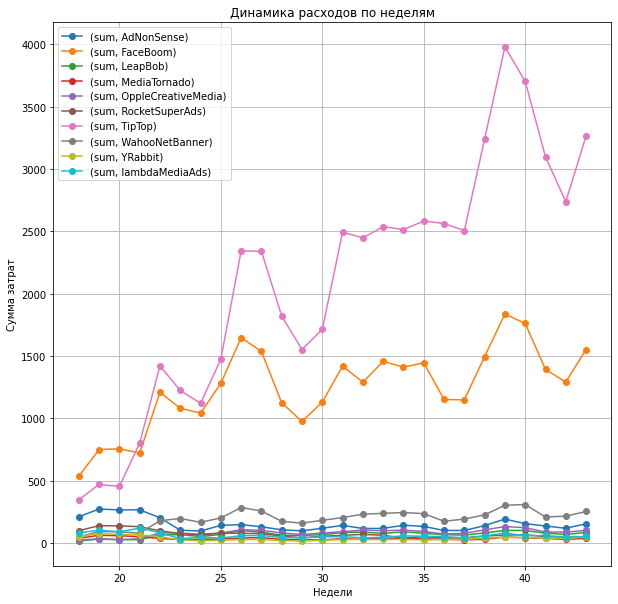

In [38]:
(costs_1.pivot_table(index = 'week',
              columns = 'channel',
              values = 'costs',
              aggfunc = ['sum'])
       .plot(kind = 'line', figsize = (10,10), grid=True, style = 'o-') 
)
plt.legend()
plt.xlabel('Недели')
plt.ylabel('Сумма затрат')
plt.title('Динамика расходов по неделям');

**Вывод:**
- Каналы TipTop и FaceBoom усиленнее других вклыдаются в рекламу. 
- TipTop вкладывает довольно большие суммы за раз в разрезе недель, FaceBoom более стабилен в суммах.

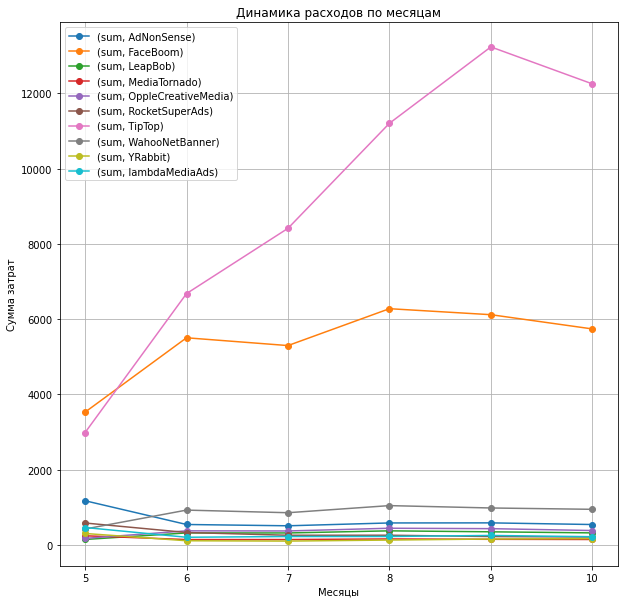

In [39]:
(costs_1.pivot_table(index = 'month',
              columns = 'channel',
              values = 'costs',
              aggfunc = ['sum'])
       .plot(kind = 'line', figsize = (10,10), grid=True, style = 'o-') 
)
plt.legend()
plt.xlabel('Месяцы')
plt.ylabel('Сумма затрат')
plt.title('Динамика расходов по месяцам');

**Вывод:**
- В месячном разрезе расходы TipTop без скачков, но стабильно повышаются. 
- Расходы FaceBoom к началу осени снижаются.

In [40]:
#Делаю группировку
cost_rate = (costs_1.groupby(['dt'])['costs']
            .sum()
            .reset_index()
         )

#Выводу график
fig = px.line(cost_rate, 
              x='dt', 
              y='costs')

fig.update_layout(title='Динамика расходов по времени',
                  xaxis_title='Даты',
                  yaxis_title='Сумма')
fig.show()

**Вывод:**
- Общие расходы на рекламу постепенно увеличиваются к концу учетного периода. 
- Пиковые значения приходятся на начало месяца - обновление подписки.

<div class="alert alert-danger">
❌ <b>Комментарий с замечанием ревьюера:</b> 


Согласно заданию:
    
Постройте визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику. Постарайтесь отразить это на одном графике.
    
Необходимо построить 2 графика (по неделям и по месяцам) и на каждом отразить динамику по всем каналам привлечения. 
</div>


<div class="alert alert-info"> <b>🎓 Комментарий студента:</b> Старый график как общую картину оставил</div>

<div class="alert alert-success">
✔️ <b>Комментарий с комплиментом ревьюера в2:</b> 

Молодец

#### 4.4 Средний САС по источникам

In [41]:
(profiles.groupby('channel')
      .agg({'acquisition_cost': 'mean'})
      .sort_values(by = 'acquisition_cost',
                   ascending = False)
)

acquisition_cost
channel                             
TipTop                      2.799003
FaceBoom                    1.113286
AdNonSense                  1.008054
lambdaMediaAds              0.724802
WahooNetBanner              0.602245
RocketSuperAds              0.412095
OppleCreativeMedia          0.250000
YRabbit                     0.218975
MediaTornado                0.218717
LeapBob                     0.210172
organic                     0.000000

**Вывод**:
- *TipTop* имеет самый большой средний САС среди всех источников - **2,8**
- *FaceBoom* идет следом, но с большим отрывом - **1,1**
- *AdNonSense* замыкает тройку  - **1,0**
- *Organic* не имеет затрат, так как пользователи пришли самостоятельно

### 5. Оценка окупаемости рекламы

- Используя графики LTV, ROI и CAC, анализируем окупаемость рекламы. 
- Принимаем условие, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. 

Задачи:
- Анализ окупаемости рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверка конверсии пользователей и динамику её изменения, аналогичный порядок действий с удержанием пользователей. Построение и изучение графики конверсии и удержания.
- Анализ окупаемости рекламы с разбивкой по устройствам,странам и рекламным каналам. Построение графиков LTV и ROI, а также графиков динамики LTV, CAC и ROI для всех указнных групп разбивки

Вопросы:
- Окупается ли реклама, направленная на привлечение пользователей в целом?
- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости?

#### 5.1 Окупаемость рекламы

In [42]:
#Уберу канал привлечения organic, так на него нет затрат.
profiles_1=profiles.query("channel != 'organic'")
profiles_1

user_id            first_ts       channel   device  \
0             599326 2019-05-07 20:58:57      FaceBoom      Mac   
1            4919697 2019-07-09 12:46:07      FaceBoom   iPhone   
3           22593348 2019-08-22 21:35:48    AdNonSense       PC   
4           31989216 2019-10-02 00:07:44       YRabbit   iPhone   
7           46006712 2019-06-30 03:46:29    AdNonSense  Android   
...              ...                 ...           ...      ...   
149999  999942424543 2019-05-24 21:03:26        TipTop   iPhone   
150001  999949280903 2019-08-12 06:47:27      FaceBoom      Mac   
150003  999956196527 2019-09-28 08:33:02        TipTop   iPhone   
150005  999976332130 2019-07-23 02:57:06        TipTop   iPhone   
150006  999979924135 2019-09-28 21:28:09  MediaTornado       PC   

               region          dt      month  payer  acquisition_cost  
0       United States  2019-05-07 2019-05-01   True          1.088172  
1       United States  2019-07-09 2019-07-01  False          1.107237  
3             Germany  2019-08-22 2019-08-01  False          0.988235  
4       United States  2019-10-02 2019-10-01  False          0.230769  
7              France  2019-06-30 2019-06-01   True          1.008000  
...               ...         ...        ...    ...               ...  
149999  United States  2019-05-24 2019-05-01  False          1.900000  
150001  United States  2019-08-12 2019-08-01  False          1.117838  
150003  United States  2019-09-28 2019-09-01  False          3.500000  
150005  United States  2019-07-23 2019-07-01  False          2.600000  
150006  United States  2019-09-28 2019-09-01  False          0.205714  

[93569 rows x 9 columns]

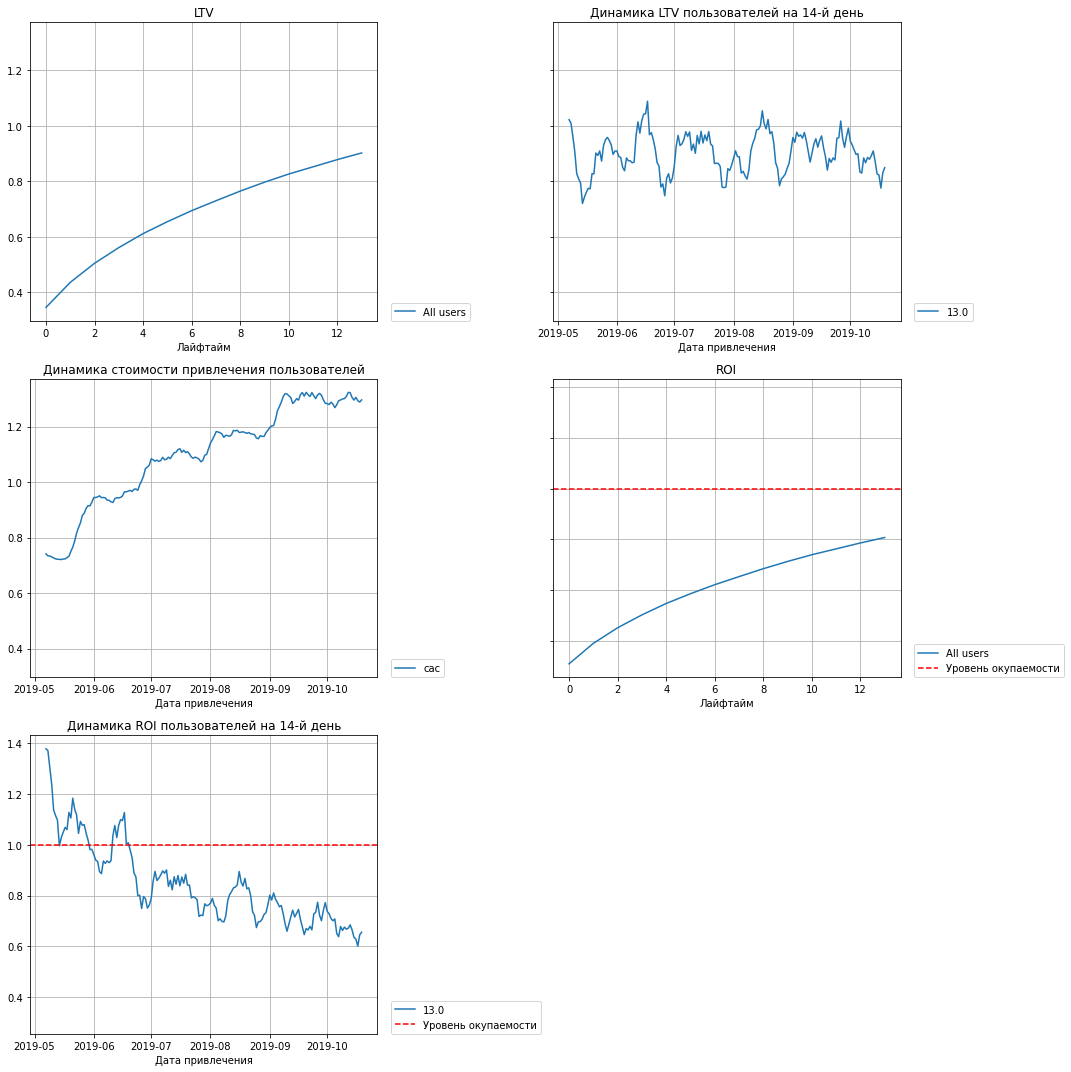

In [43]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_1, orders, observation_date, horizon_days
)
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

**Выводы:**
- Реклама не окупается, к концу учетного периода чуть выше 80%
- Динамика жизни пользователей в целом стабильна
- Затраты на привлечение к концу учетного периода увеличиваются, но возврат инвестиций уменьшается, уходя с середины июня в зону неокупаемости.

#### 5.2 Конверсия и ее динамика

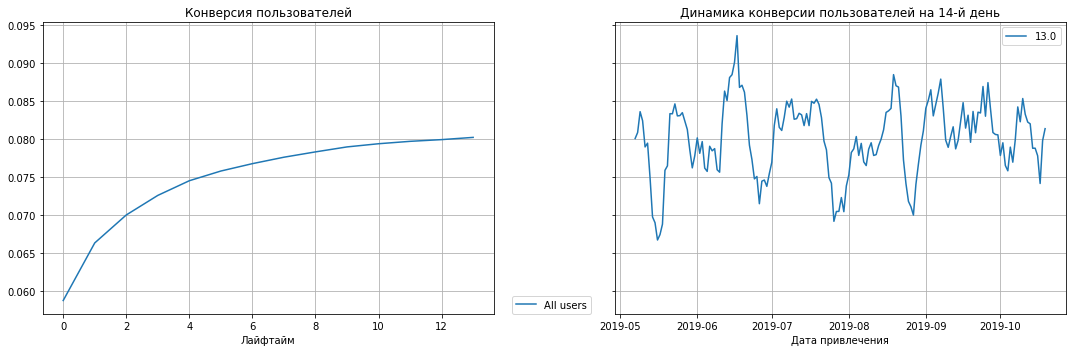

In [44]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_1, orders, observation_date, horizon_days
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

**Вывод:**
- Конверсия общая держится на уровне **80%**
- Динамика конверсии так же стабильная, отрицательные пиковые значения приходятся на конец месяца, положительные  - на начало. Клиенты оплачивают новый период, либо решают не продлевать и перестают пользоваться подпиской.

#### 5.3 Удержание и его динамика

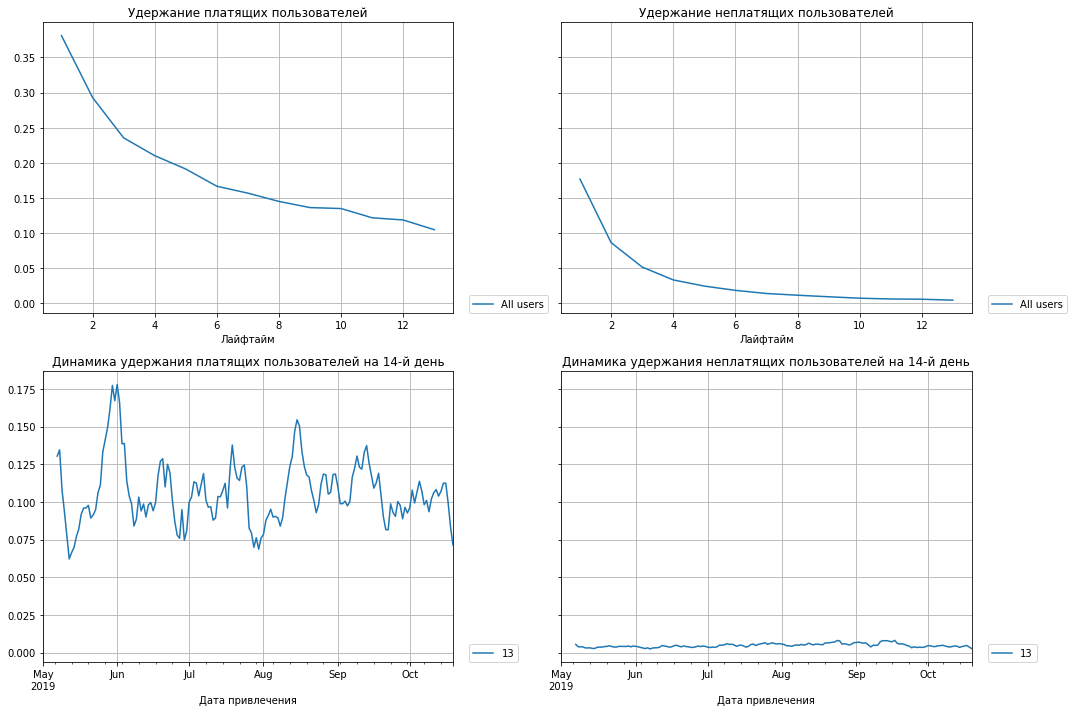

In [45]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_1, visits, observation_date, horizon_days
)

plot_retention(retention_grouped, retention_history, horizon_days)

**Вывод:**
- Кривая удержания без аномалий.
- Пиковые значения в динамике так же в целом стабильны. 

#### 5.4 Окупаемость по критериям

##### 5.4.1 Устройства

###### 5.4.1.1 LTV, CAC, ROI

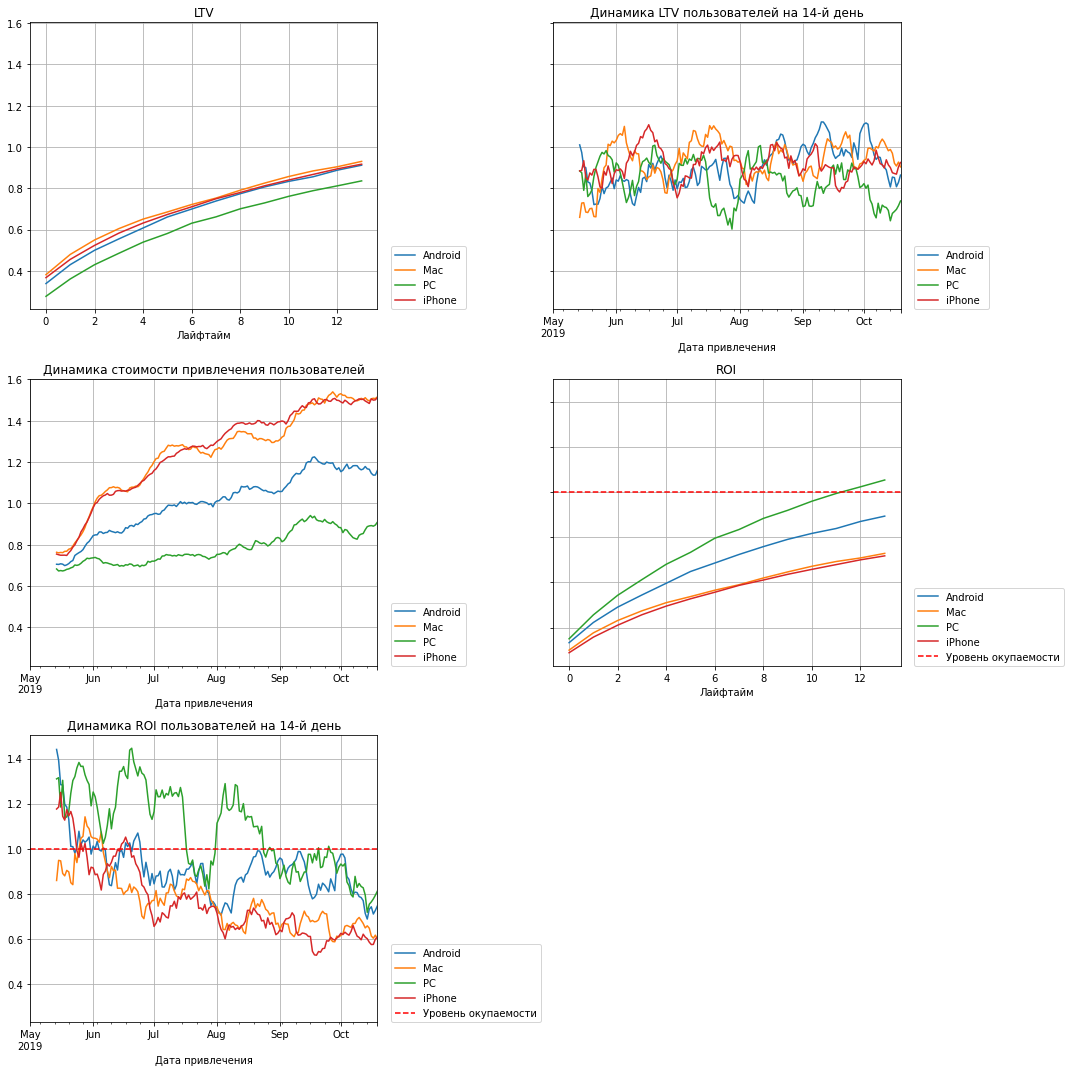

In [46]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_1, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

**Вывод:**
- Затраты на привлечение пользователей **PC** минимальные, это единственная платформа, где затраты окупаются.
- Самые большие затраты у продуктов *Apple* - **iPhone** и **Mac**, но по окупаемости они являются аутсайдерами.
- В целом окупаемость идет на снижение и к концу месяца уходит в минус.
- Динамика LTV на всех платформах в целом стабильна.

###### 5.4.1.2 Conversion, retention

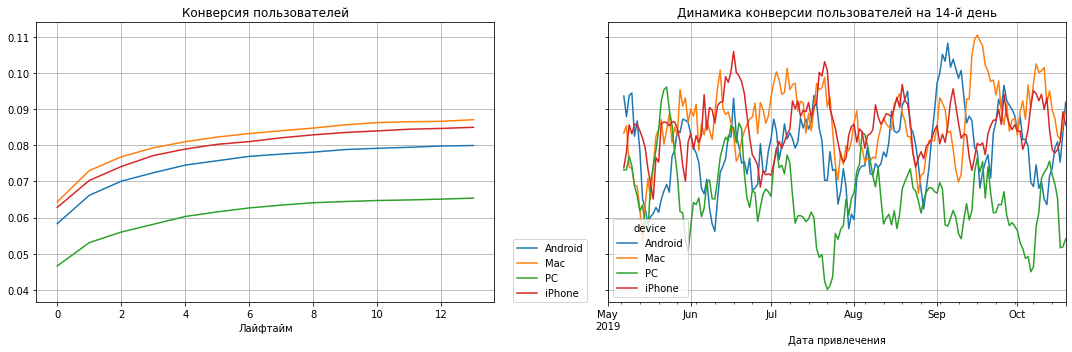

In [47]:
dimensions = ['device']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_1, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

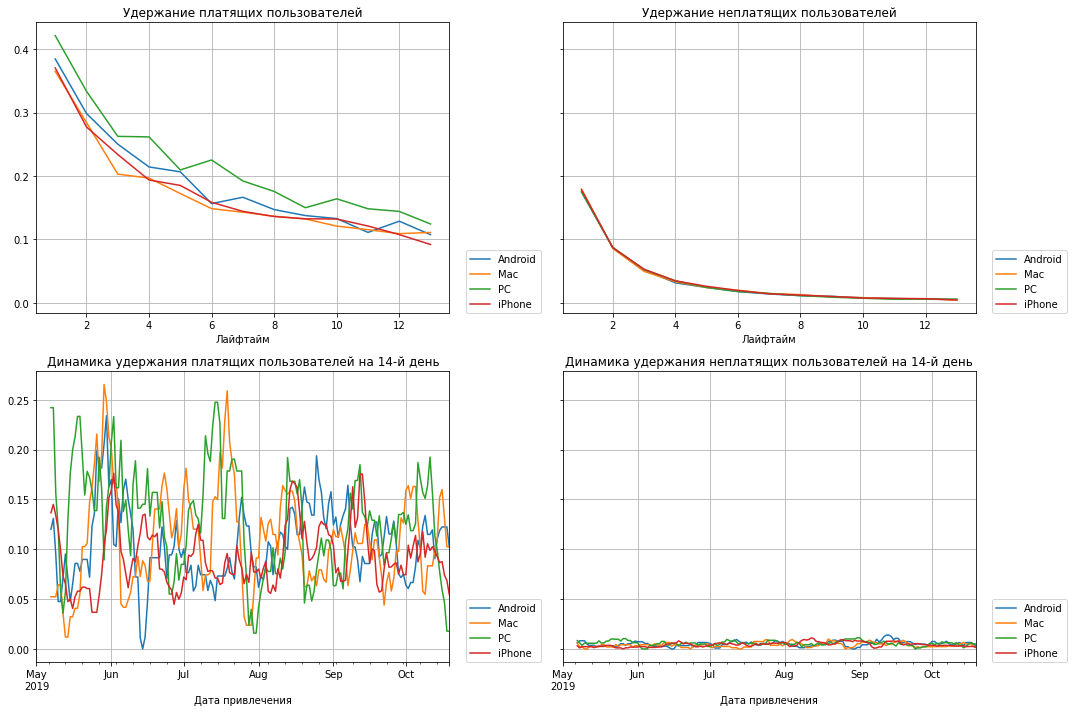

In [48]:
dimensions = ['device']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles_1, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

**Выводы**: 
- Пользователи продукцией *Apple* окупаются лучше остальных, конверсия в районе **85%**.
- Самая низкая конверсия у пользователей *PC* - чуть ниже **70%**
- При высокой конверсии пользователи *Apple* удерживаются хуже всех.
- Пользователи *PC* наоборот лучше удерживаются, имея низкую конверсию.

##### 5.4.2 Регионы

###### 5.4.2.1 LTV, CAC, ROI

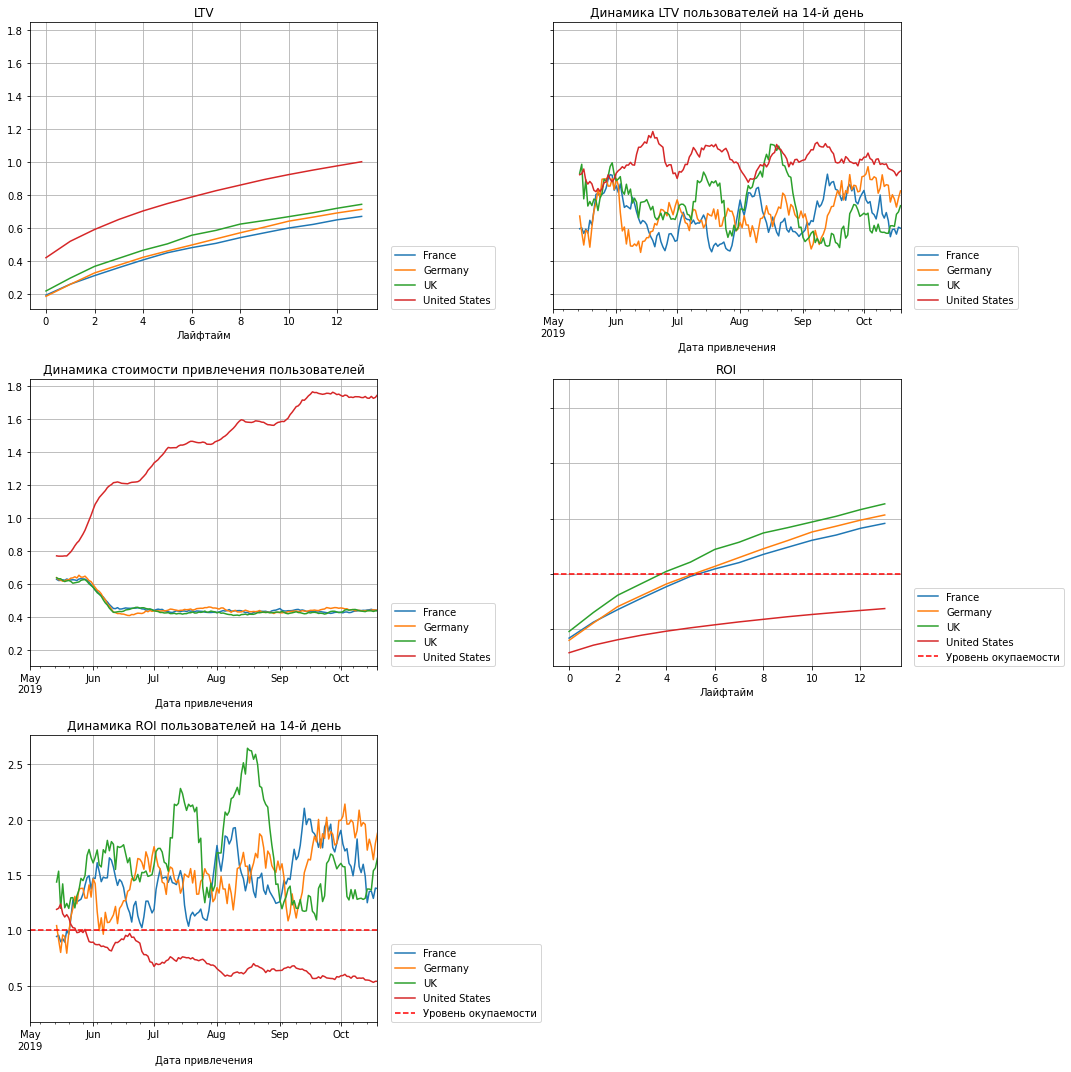

In [49]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_1, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

**Вывод:**
- Пользователи **США** самые дорогие по стоиомости привлечения, при этом окупаемость в краткосрочном периоде отрицательная, а в долгосрочном уходит в минус к концу первого месяца учетного периода.
- В остальных странах затраты на рекламу уходят на практический одинаковый низкий уровень, что ведет к ее окупаемости.
- Американцы регулярнее европейцев совершают покупки - LTV США преобладает над Европой. Местами Великобритания догоняет США, но это краткосрочное явление.

###### 5.4.2.2 Conversion, retention

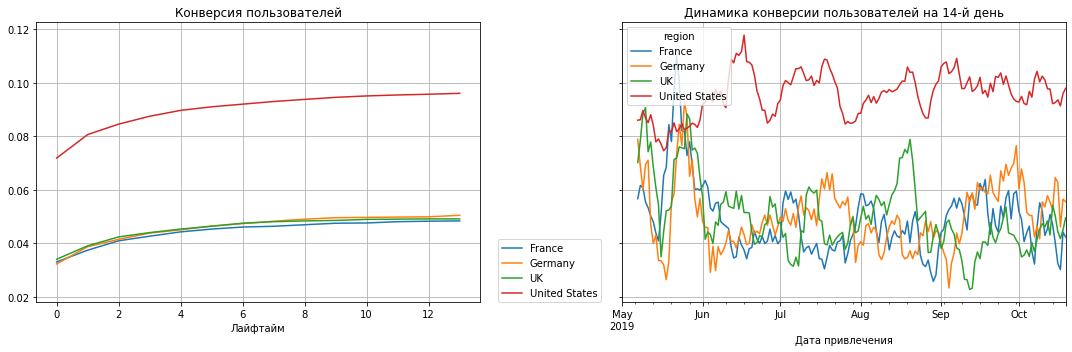

In [50]:
dimensions = ['region']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_1, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

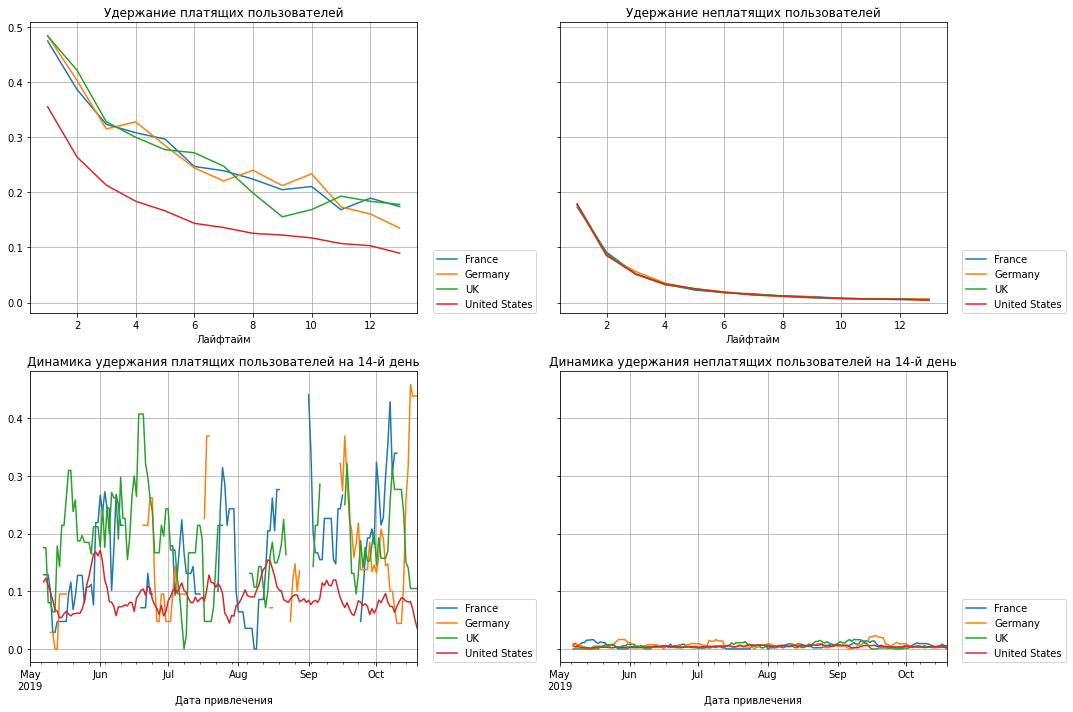

In [51]:
dimensions = ['region']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles_1, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

**Вывод:**
- Пользователи **США** конвертируются лучше остальных стран - в районе **90%**, конверсия остальных стран держится в районе **50%**.
- При этом удержание пользователей **США** остает так же с большим отрывом от остальных стран.
- Несмотря на плохое удержание, пользователи **США** пользуются приложением постоянно, тогда как в других странах наблюдаются пробелы, что может говорить о том, что приложением перестают пользоваться, либо не совершают повторные покупки.

##### 5.4.3 Окупаемость рекламы по источникам

###### 5.4.3.1 LTV, CAC, ROI

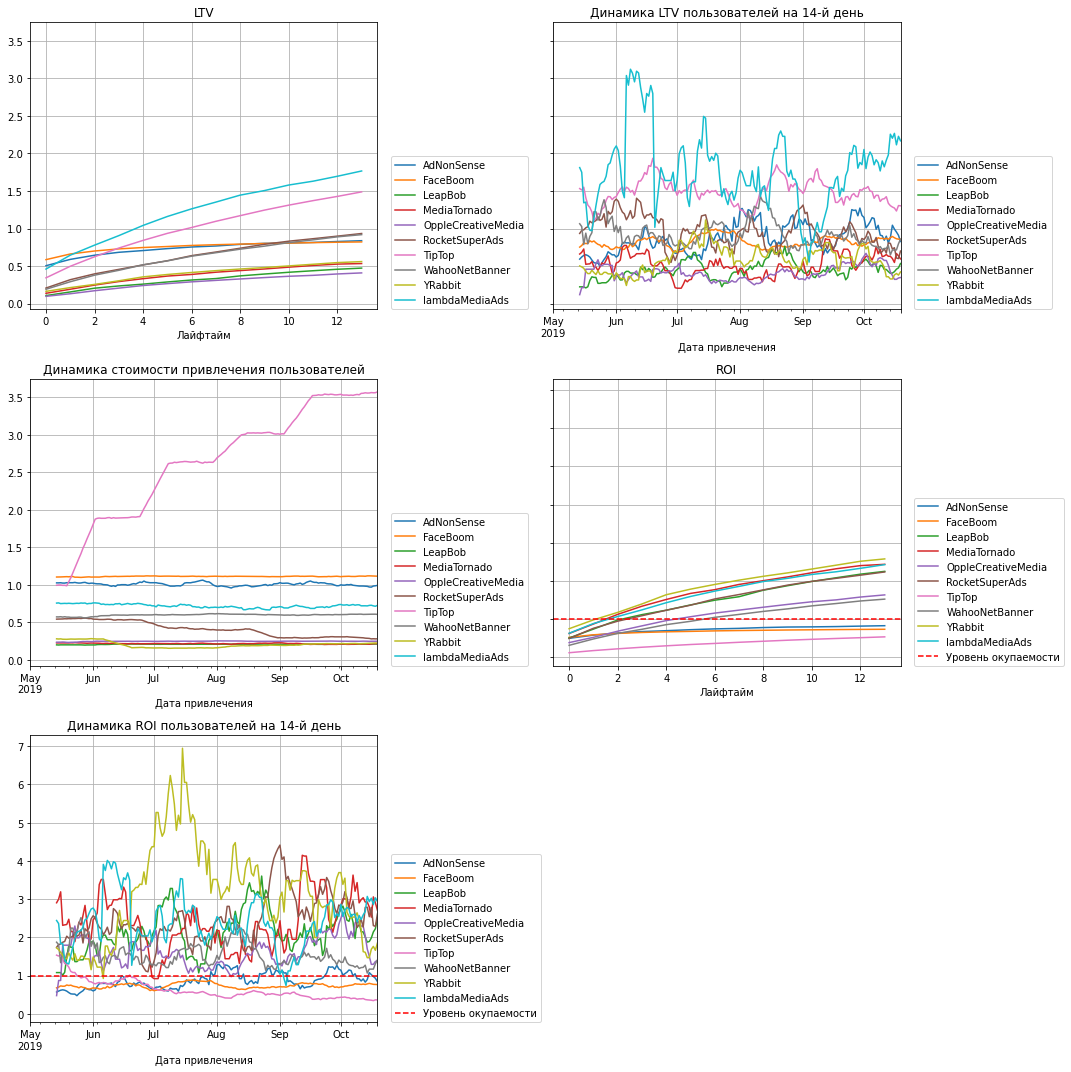

In [52]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_1, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

**Вывод:**
- В отличие от остальных показателей, учет данных по каналам начинается с середины мая, возможно поздний запуск рекламы.
- Большая часть каналов на протяжении всего учетного периода тратят на рекламу одну и ту же сумму.
- Исключение составляют **TipTop**, вкладывающие каждый месяц все больше средств и **RocketSuprAds**, которые постепенно уменьшили затраты на рекламу.
- Самая высокая окупаемость у канала **YRabbit**, а самая низкая у **TipTop** с самыми большими затратами на рекламу
- По LTV выделяется **LambdaMediaAds**, который имеет самую высокую степень жизни клиентов. С июня по иилю зафиксирован очень большой прирост по сравнению с другими каналами. При этом затраты на рекламу у канала стабильно низкие. Так же высокий LTV показатель и у привычного нам **TipTop**

###### 5.4.3.2 Conversion, retention

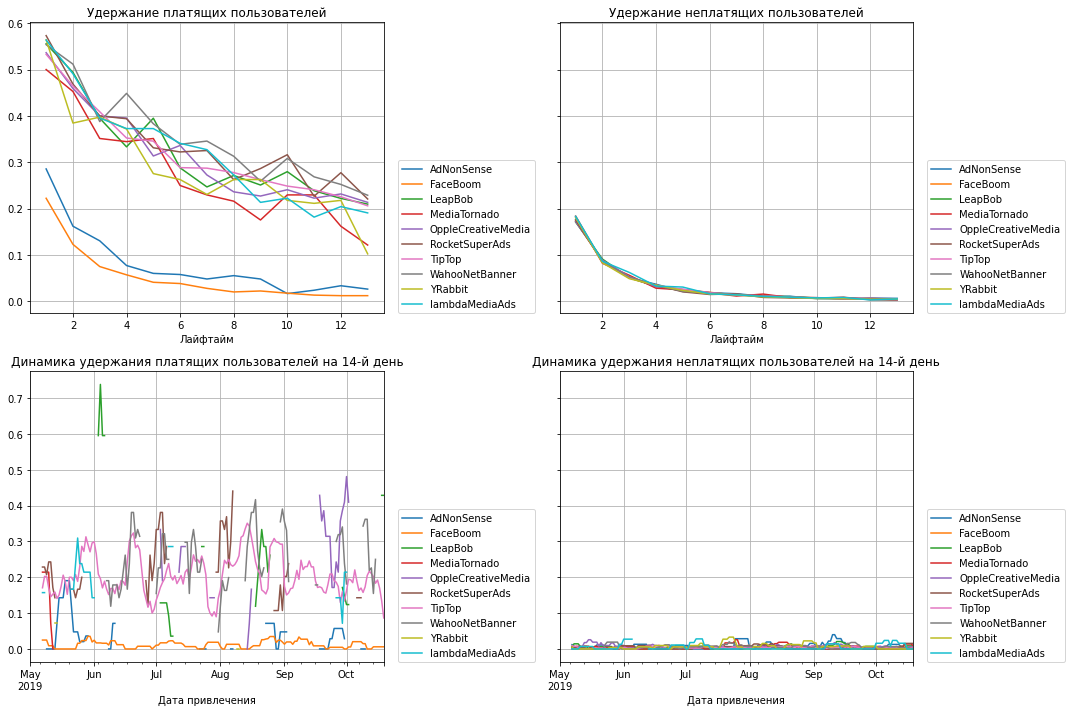

In [53]:
dimensions = ['channel']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles_1, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

**Вывод**:
- **AdNonSense** и **FaceBoom** имеют самые низкие показатели удержания среди всех каналов.
- Каналы **FaceBoom** и **TipTop** являются каналами чья динамика привлечения не прерывается в течение всего учетного периода.

##### 5.4.4 Разбивка каналов по регионам

Разделю каналы по рынкам - америнскому и европейскому

In [54]:
profiles_usa = profiles.query("region == 'United States' and channel != 'organic'") #USA
profiles_eu = profiles.query("region != 'United States'and channel != 'organic'") #EU

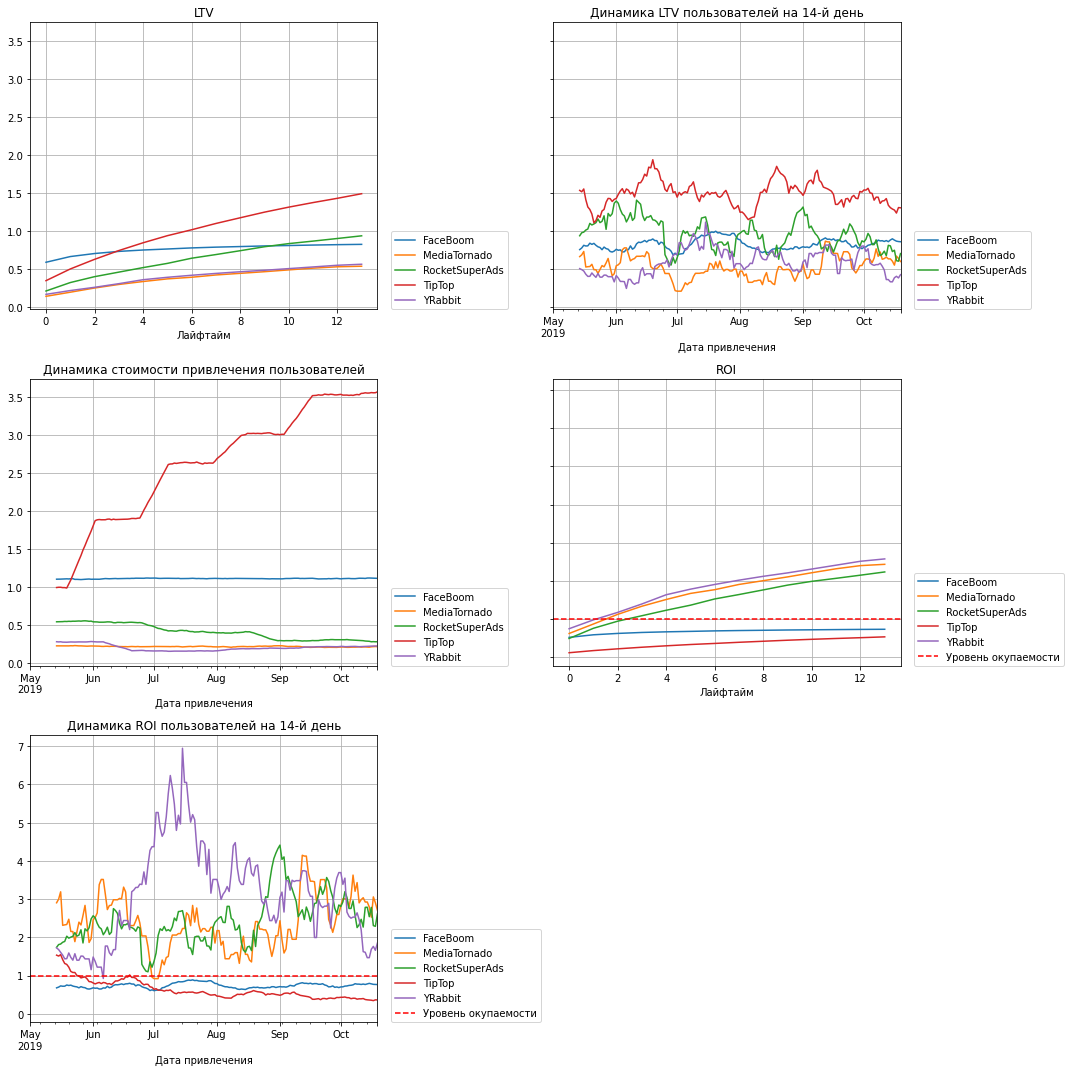

In [55]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_usa, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

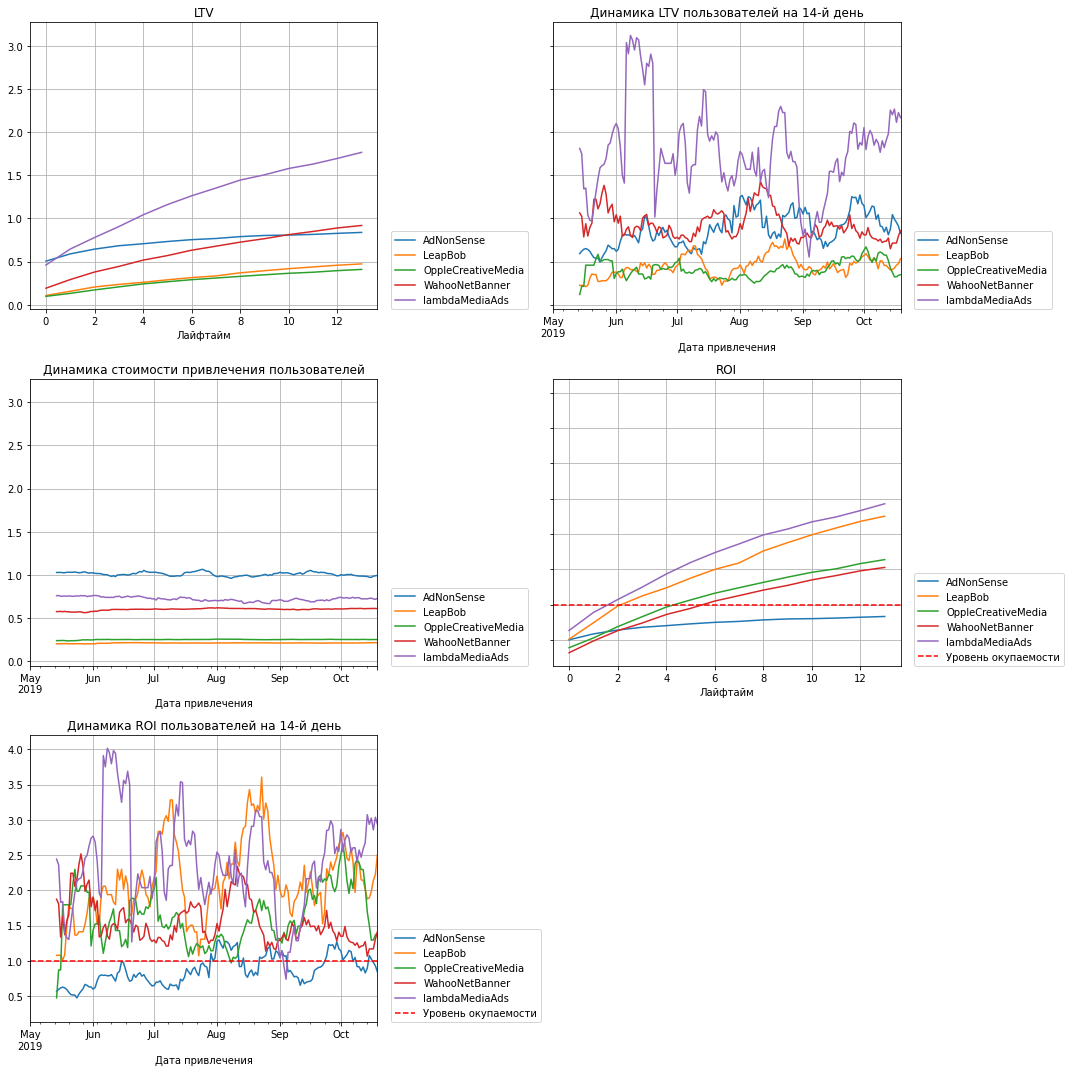

In [56]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_eu, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

### 6. Вывод


**Возможные причины неэффективности:**
- Большие расходы на привлечение пользователей из США, которые из всех рассматриваемых стран пользуются приложением стабильно.
- Некоторые каналы привлечения работают плохо, на что указывает прерывистая пользовательская активность.
- Большие расходы для пользователей продукцией Apple.

**Рекомендации:**
- Уменьшить расходы на рекламу для пользователей США. Они пользуются подпиской стабильно, острой необходимости вкладывать большие средства нет. 
- Это же применимо к пользователям Apple, так как данными устройствами пользуются много людей.
- Пересмотреть каналы привлечения и исключить те, где наименее слабый приток пользователей. На американском рынке ниже окупаемости находятся самые большие по числу клиентов каналы - **TipTop** и **FaceBoom**. Для них, в оснобенности для **TipTop**, целесообразно уменьшить расходы, так как ежемесячное увеличение вложенных средств не ведет к их окупаемости.
- На европейском рынке следует пересмотреть расходы по каналу **AdNonSense**, как единственному, который не окупается.

**Рекомендации по распределению бюджета:**
- На два рынка есть всего три канала, которые не окупаются - **TipTop** и **FaceBoom** для USA и **AdNonSense** для EU.
- Все эти три канала имеют максимальные в своих категориях траты на рекламу.
- Избыточный бюджет можно распределить на каналы, которые окупаются, но находятся близко к нижней границе.
- Для американского рынка это канал **RocketSuperAds**.
- Для европйского рынка это каналы **OppleCreativeMedia** и **WahooNetBanner**.
- Если увеличение затрат на рекламу приведет к уменьшению окупаемости выбранных каналов, то целесообразно либо снова пересмотреть каналы для перераспределения бюджета, либо рассмотреть вопрос об уменьшении бюджета на рекламу.

In [57]:
print('Код загружен')

Код загружен
